---
## Note from the Teachers:
We added a header with information about your project. 
This is useful since we want to keep a database of all the cool projects participants have made during the courses.
We will save the code in our database and host on github a page to show all the projects. Therefore it is more practical to add some information in the header of each notebook.
Thanks a lot for the understanding and for taking care of it.

You can delete this cell if you want

---

# Project Name (replace with your project name)
Project description (replace with your project description, you can use the same from the `INFO.md` file.

### Project Repo 
link (replace if you have your own repo, otherwise delete)

## Participants:
Please list here all the participants alongside with any information you may want to be visible. This will be hosted on a opencampus.sh repository, so if you want to keep a connection to your github user include this information here. 

### Course and Semester
Add here in which course and in which semester it was done.

### License
If you are releasing the software under some certain license, you can mention it and also include the `LICENSE.md` file in the folder

---

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data/face_age"

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
batch_size = 32

#Fix seed to achieve determinism
fixed_seed = 42

#10% of data reserved for validation set
validation_split=0.1

#Load both training and validation set. Sets are shuffled by default
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=fixed_seed,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=fixed_seed,
  batch_size=batch_size)


Found 5351 files belonging to 46 classes.
Using 4816 files for training.


2021-12-14 16:54:07.866698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5374 files belonging to 47 classes.
Using 537 files for validation.


In [5]:
#Labels
class_names = train_ds.class_names
print(class_names)
#Elements of dataset
print(train_ds.element_spec)
print(train_ds)

['001', '002', '003', '008', '009', '010', '011', '012', '013', '014', '015', '018', '019', '022', '024', '032', '033', '034', '036', '039', '040', '043', '044', '047', '050', '054', '055', '056', '057', '059', '060', '062', '065', '069', '074', '076', '078', '080', '084', '086', '091', '093', '095', '096', '099', '110']
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


(-0.5, 255.5, 255.5, -0.5)

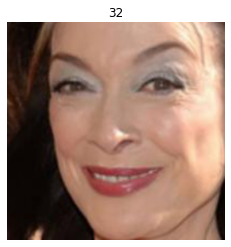

In [13]:
#Show one random image from dataset, including label

example_batch = train_ds.take(1)

#x and y are one batch array of examples and labels
x,y = iter(example_batch).get_next()

plt.imshow(x[0].numpy().astype("uint8"))
plt.title(y[0].numpy())
plt.axis("off")

In [7]:
#Count the number of examples for each label
from collections import defaultdict

age_dist = defaultdict(int)

for x_batch,y_batch in train_ds.as_numpy_iterator():
   for i in range(len(y_batch)):
       age_dist[y_batch[i]] += 1


Text(0, 0.5, '#Examples')

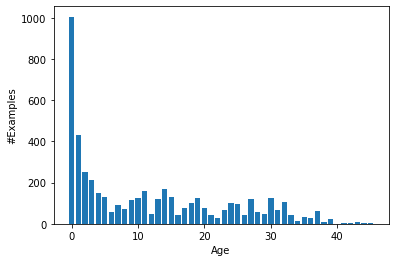

In [8]:
#Plot above count
plt.bar(list(age_dist.keys()), age_dist.values())
plt.xlabel('Age')
plt.ylabel('#Examples')

Papers:

* S. N. Kohail:  
Using Artificial Neural Network for Human Age Estimation Based on Facial Images  
2012 International Conference on Innovations in Information Technology (IIT)  
https://www.inf.uni-hamburg.de/en/inst/ab/lt/people/alumni/sarah-kohail/kohail-age-estimation.pdf

* Z. Qawaqneh, A. Abu Mallouh & B. D. Barkana:  
Deep Convolutional Neural Network for Age Estimation based on VGG-Face Model  
https://arxiv.org/ftp/arxiv/papers/1709/1709.01664.pdf

* N. Hewahi, A. Olwan, N. Tubeel, S. El-Asar, Z. Abu-Sultan:  
Age Estimation based on Neural Networks using Face Features  
Journal of Emerging Trends in Computing and Information Sciences 1:2, October 2010  
https://www.researchgate.net/publication/47277288_Age_Estimation_based_on_Neural_Networks_using_Face_Features

* R. Rahadian & S. Suyanto:  
Deep Residual Neural Network for Age Classification with Face Image  
2019 International Seminar on Research of Information Technology and Intelligent Systems (ISRITI)  
https://ieeexplore.ieee.org/document/9034664

* M. M. Islam & J.-H. Baek:  
Deep Learning Based Real Age and Gender Estimation from Unconstrained Face Image towards Smart Store Customer Relationship Management  
Applied Sciences 2021, 11  
https://www.mdpi.com/2076-3417/11/10/4549/pdf

* A. Othmania, A. R. Taleb, H. Abdelkawy & A. Hadid:  
Age estimation from faces using deep learning: A comparative analysis  
Computer Vision and Image Understanding 196, July 2020  
https://www.sciencedirect.com/science/article/abs/pii/S1077314220300424

Additional links:

* https://towardsdatascience.com/age-detection-using-facial-images-traditional-machine-learning-vs-deep-learning-2437b2feeab2